
### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [1]:
!pip install transformers

[Transformers library doc](https://huggingface.co/transformers/)

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Importing the dataset

In [3]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
print(df.shape)
df.head()

(6920, 2)


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


### Using BERT for text classification.

Let's now load a pre-trained BERT model.

In [4]:
# For DistilBERT, Load pretrained model/tokenizer:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [6]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model_structure(model)

embeddings:
            word_embeddings
            position_embeddings
            LayerNorm
            dropout
transformer:
             layer:
                    0:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                            lin1
                            lin2
                            activation
                       output_layer_norm
                    1:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                   

### Preparing the dataset

In [40]:
from torch.utils.data import Dataset, random_split

class ReviewsDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels):
        self.labels = labels
        self.tokenized = [
            tokenizer.encode(review)
            for review in reviews
        ]
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

dataset = ReviewsDataset(reviews=df[0], tokenizer=tokenizer, labels=df[1])

# DON'T CHANGE
train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2)
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 5536
Number of validation examples: 692
Number of testing examples: 692


In [16]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [44]:
from torch.utils.data import DataLoader

name_for_seq = 'tokenized'

def collate_fn(batch):

    def get_padded(values, name_for_seq):
        max_len = 0
        for value in values:
            seq_len = len(value[name_for_seq])
            if seq_len > max_len:
                max_len = seq_len

        padded_seqs = list()
        attention_mask = list()
        labels = list()
        for value in values:
            tokenized_review = value[name_for_seq]
            tokenized_review_len = len(tokenized_review)
            
            padded_seqs.append(tokenized_review + [0]*(max_len-tokenized_review_len))
            attention_mask.append([1] * tokenized_review_len + [0] * (max_len-tokenized_review_len))
            labels.append(int(value['label']))
        
        attention_mask = np.array(attention_mask)
        padded_seqs = np.array(padded_seqs)
        
        return padded_seqs, labels, attention_mask

    inputs, labels, attention_mask = get_padded(batch, name_for_seq)

    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), 'attention_mask' : torch.tensor(attention_mask)}

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data), collate_fn=collate_fn)

### Baseline

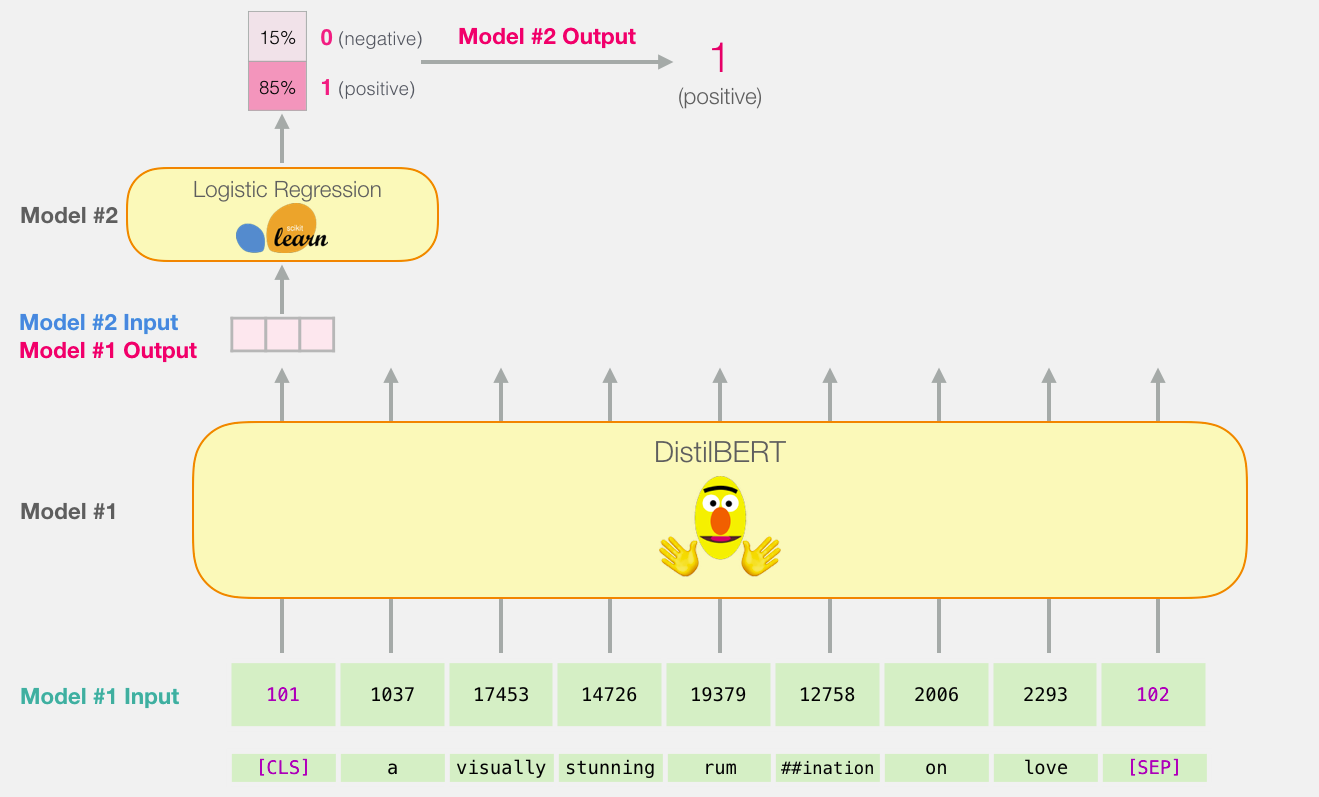

In [81]:
from tqdm.notebook import tqdm

def get_xy(model, device, loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):

            model = model.to(device)
            inputs_ids = batch['inputs'].to(device)
            labels_ids = batch['labels']
            attention_mask_ids = batch['attention_mask'].to(device)
            
            input_for_model = (inputs_ids, attention_mask_ids)
            last_hidden_states = model(*input_for_model).last_hidden_state

            features.append(last_hidden_states.cpu())
            labels.append(labels_ids)

    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    return features, labels

In [82]:
train_features, train_labels = get_xy(model, device, train_loader)
valid_features, valid_labels = get_xy(model, device, valid_loader)
test_features, test_labels = get_xy(model, device, test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [83]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.8164739884393064

### Fine-Tuning BERT

Define the model

In [127]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, lin_hid_dim, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model
        self.last_state_dim = 768
        self.lin_hid_dim = lin_hid_dim
        self.dropout = torch.nn.Dropout(p=dropout)

        self.projection = torch.nn.Sequential(
            torch.nn.Linear(self.last_state_dim, lin_hid_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(lin_hid_dim, lin_hid_dim)
        )
        
        self.projection_proba = torch.nn.Linear(lin_hid_dim, 1)

    def forward(self, inputs, attention_mask, use_dropout=True, return_logits=True):

        features = self.projection(self.bert(inputs, attention_mask).last_hidden_state[:, 0, :])
        if use_dropout:
            features = self.dropout(features)
        if return_logits:
            return torch.squeeze(torch.sigmoid(self.projection_proba(features)), dim=-1)
        else:
            return features

In [136]:
import torch.optim as optim

lin_hid_dim = 1024

# DON'T CHANGE
model = model_class.from_pretrained(pretrained_weights).to(device)
bert_clf = BertClassifier(model, lin_hid_dim).to(device)
# you can change
optimizer = optim.Adam(bert_clf.parameters(), lr=2e-5)
criterion = nn.BCELoss()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [137]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    model.train()
    for i, batch in enumerate(iterator):

        optimizer.zero_grad()

        model = model.to(device)
        inputs_ids = batch['inputs'].to(device)
        labels_ids = batch['labels'].to(device)
        attention_mask_ids = batch['attention_mask'].to(device)
        
        input_for_model = {
            'inputs': inputs_ids, 
            'attention_mask': attention_mask_ids
        }
        proba = model(**input_for_model)

        loss = criterion(proba, labels_ids)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0
    history = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            
            model = model.to(device)
            inputs_ids = batch['inputs'].to(device)
            labels_ids = batch['labels'].to(device)
            attention_mask_ids = batch['attention_mask'].to(device)

            input_for_model = {
                'inputs': inputs_ids, 
                'attention_mask': attention_mask_ids
            }
            proba = model(**input_for_model)

            loss = criterion(proba, labels_ids)

            epoch_loss += loss.item()

    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [138]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

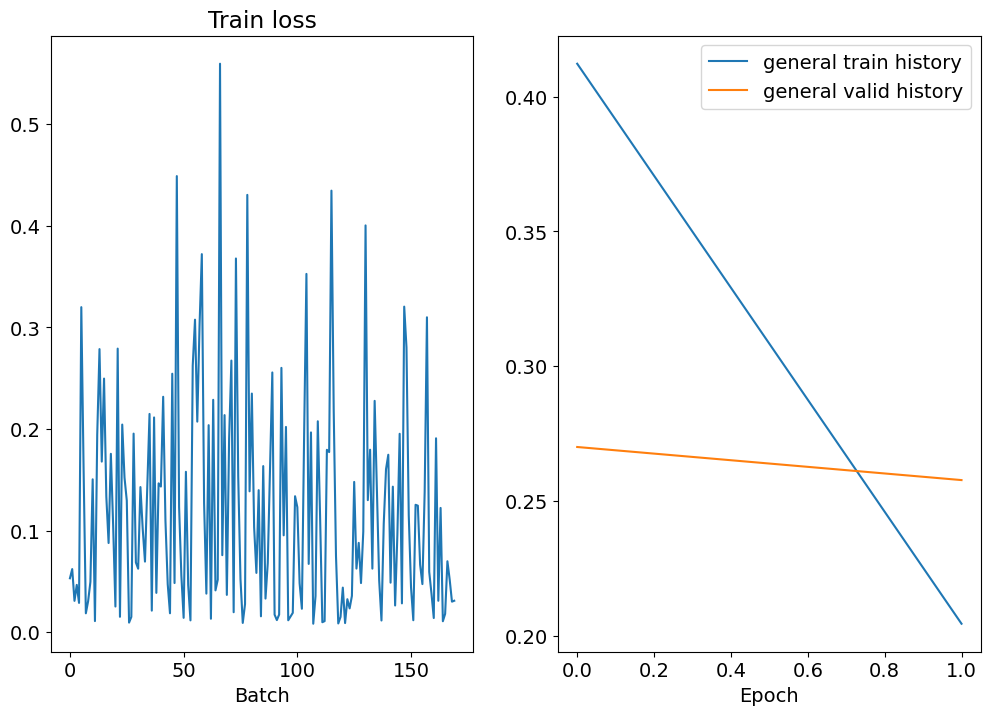

Epoch: 03 | Time: 0m 18s
	Train Loss: 0.119 | Train PPL:   1.126
	 Val. Loss: 0.320 |  Val. PPL:   1.377


In [139]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(bert_clf, valid_loader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [143]:
#best_model = BertClassifier(model, lin_hid_dim).to(device)
#best_model.load_state_dict(torch.load('best-val-model.pt'))

pred_labels = []
true_labels = []
boarder = 0.5

bert_clf.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        bert_clf = bert_clf.to(device)
        inputs_ids = batch['inputs'].to(device)
        labels_ids = batch['labels']
        attention_mask_ids = batch['attention_mask'].to(device)

        input_for_model = {
            'inputs': inputs_ids, 
            'attention_mask': attention_mask_ids
        }
        proba = bert_clf(**input_for_model).cpu().detach()
        proba[proba > boarder] = 1
        proba[proba <= boarder] = 0
        preds = proba.numpy()
        
        true_labels.append(labels_ids.numpy())
        pred_labels.append(preds)


0it [00:00, ?it/s]

In [144]:
from sklearn.metrics import accuracy_score

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0.8757225433526011

In [145]:
assert accuracy_score(true_labels, pred_labels) >= 0.86